## Seminary 1

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json

### Task 1: Representation

In [2]:
def load_data(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    return data

def parse_json(data):
    N = data["num_papers"]
    K = data["num_reviewers"]
    R = data["reviewer_capacity"]
    min_reviews_per_paper = data["min_reviews_per_paper"]
    max_reviews_per_paper = data["max_reviews_per_paper"]
    
    preference_matrix = np.array(data["preferences"])             ### make all the matrices as ... matrices ofc
    friendship_matrix = np.array(data["friendships"])
    authorship_matrix = np.array(data["authorship"])
    
    return (N, K, R, min_reviews_per_paper, max_reviews_per_paper,
            preference_matrix, friendship_matrix, authorship_matrix)

In [58]:
def fitness_function(assignment, preference_matrix, friendship_matrix, authorship_matrix,
                     capacity, min_reviews_per_paper, max_reviews_per_paper):
    
    fitness = np.sum(assignment * preference_matrix)
    penalty = 0

    # fitness += np.sum(assignment * preference_matrix)
    for j in range(assignment.shape[0]):
        reviews_assigned = assignment[j, :].sum()
        if reviews_assigned > capacity:
            penalty += (reviews_assigned - capacity) * 2

    for i in range(assignment.shape[1]):
        reviews_needed = assignment[:, i].sum()
        if reviews_needed < min_reviews_per_paper:
            penalty += (min_reviews_per_paper - reviews_needed) * 2
        elif reviews_needed > max_reviews_per_paper:
            penalty += (reviews_needed - max_reviews_per_paper) * 2

    for i in range(assignment.shape[0]):
        for j in range(assignment.shape[1]):
            if assignment[i, j] == 1:
                for k in range(authorship_matrix[:, j].shape[0]):
                    if authorship_matrix[k, j] == 1 and friendship_matrix[i, k] == 1:
                        penalty += 5
                # for k in range(j + 1, assignment.shape[1]):
                #     if assignment[i, k] == 1 and friendship_matrix[j, k] == 1:
                #         penalty += 5

    # penalty += np.sum(assignment * friendship_matrix) * 5
    penalty += np.sum(assignment * authorship_matrix) * 6
    return fitness - penalty

In [59]:
def generate_random_assignment(num_papers, num_reviewers, reviewer_capacity,
                               min_reviews_per_paper, max_reviews_per_paper):
    
    assignment = np.zeros((num_reviewers, num_papers), dtype=int)
    
    for i in range(num_papers):
        reviewers = np.random.choice(range(num_reviewers), 
                                     size=np.random.randint(min_reviews_per_paper, max_reviews_per_paper + 1), 
                                     replace=False)
        assignment[reviewers, i] = 1
    
    for j in range(num_reviewers):
        while assignment[j, :].sum() > reviewer_capacity:
            assigned_papers = np.where(assignment[j, :] == 1)[0]
            paper_to_remove = np.random.choice(assigned_papers)
            assignment[j, paper_to_remove] = 0

    return assignment

In [89]:
import random

def initialize_population(pop_size, N, K, R, min_reviews, max_reviews):                                #### generate the first population
    return [generate_random_assignment(N, K, R, min_reviews, max_reviews) for _ in range(pop_size)]

# def select_parents(population, fitness_scores):                                   #### find the parents
#     fitness_sum = sum(fitness_scores)
#     probabilities = [score / fitness_sum for score in fitness_scores]
#     parents = random.choices(population, weights=probabilities, k=2)
#     return parents
 
# def crossover(parent1, parent2):                                                  #### crossover by swapping
#     num_rev, num_pap = parent1.shape
#     crossover_point = random.randint(0, num_rev - 1)
#     child1 = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
#     child2 = np.vstack((parent2[:crossover_point], parent1[crossover_point:]))
#     return child1, child2

def mutate(assignment, R, min_reviews, max_reviews):                             #### mutate by flipping a random entry 0->1 or 1->0
    num_rev, num_pap = assignment.shape
    num_mutates = random.randint(1, 5)
    for n in range(num_mutates):
        i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
        assignment[i, j] = 1 - assignment[i, j]  
    
        if assignment[i, :].sum() > R:
            assignment[i, j] = 0
        if assignment[i, :].sum() < min_reviews:
            assignment[i, j] = 1
        elif assignment[i, :].sum() > max_reviews:
            assignment[i, j] = 0
    return assignment

def mutate_swap(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    k, l = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    
    assignment[i, j], assignment[k, l] = assignment[k, l], assignment[i, j]
    
    if assignment[i, :].sum() > R:
        assignment[i, j] = 0
    if assignment[i, :].sum() < min_reviews:
        assignment[i, j] = 1
    elif assignment[i, :].sum() > max_reviews:
        assignment[i, j] = 0
    
    if assignment[k, :].sum() > R:
        assignment[k, l] = 0
    if assignment[k, :].sum() < min_reviews:
        assignment[k, l] = 1
    elif assignment[k, :].sum() > max_reviews:
        assignment[k, l] = 0
    
    return assignment

def mutate_scramble(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    np.random.shuffle(assignment[i, start:end+1])
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

def mutate_inversion(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    assignment[i, start:end+1] = assignment[i, start:end+1][::-1]
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

def crossover_one_point(parent1, parent2):
    num_rev, num_pap = parent1.shape
    crossover_point = random.randint(0, num_rev - 1)
    child1 = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.vstack((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

def crossover_two_point(parent1, parent2):
    num_rev, num_pap = parent1.shape
    point1, point2 = sorted(random.sample(range(num_rev), 2))
    child1 = np.vstack((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    child2 = np.vstack((parent2[:point1], parent1[point1:point2], parent2[point2:]))
    return child1, child2

def crossover_uniform(parent1, parent2):
    num_rev, num_pap = parent1.shape
    child1, child2 = np.zeros_like(parent1), np.zeros_like(parent2)
    for i in range(num_rev):
        if random.random() > 0.5:
            child1[i, :], child2[i, :] = parent1[i, :], parent2[i, :]
        else:
            child1[i, :], child2[i, :] = parent2[i, :], parent1[i, :]
    return child1, child2

def proportional_selection(population, fitness_scores):
    fitness_sum = sum(fitness_scores)
    probabilities = [score / fitness_sum for score in fitness_scores]
    parents = random.choices(population, weights=probabilities, k=2)
    return parents

def rank_based_selection(population, fitness_scores):
    ranks = np.argsort(np.argsort(fitness_scores)) + 1
    total_rank = np.sum(ranks)
    
    probabilities = ranks / total_rank
    parents = random.choices(population, weights=probabilities, k=2)
    
    return parents

def tournament_selection(population, fitness_scores, tournament_size=10):
    selected = random.sample(list(zip(population, fitness_scores)), tournament_size)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0], selected[1][0]

def select_parents(population, fitness_scores, selection_method='proportional'):
    if selection_method == 'proportional':
        return proportional_selection(population, fitness_scores)
    elif selection_method == 'rank-based':
        return rank_based_selection(population, fitness_scores)
    elif selection_method == 'tournament':
        return tournament_selection(population, fitness_scores)
    else:
        raise ValueError("Invalid selection method")
    
def select_crossover(crossover_method, parent1, parent2):
    if crossover_method == 'one-point':
        return crossover_one_point(parent1, parent2)
    elif crossover_method == 'two-point':
        return crossover_two_point(parent1, parent2)
    elif crossover_method == 'uniform':
        return crossover_uniform(parent1, parent2)
    else:
        raise ValueError("Invalid crossover method")
    
def select_mutation(mutation_method, child, R, min_reviews, max_reviews):
    if mutation_method == 'random':
        return mutate(child, R, min_reviews, max_reviews)
    elif mutation_method == 'swap':
        return mutate_swap(child, R, min_reviews, max_reviews)
    elif mutation_method == 'scramble':
        return mutate_scramble(child, R, min_reviews, max_reviews)
    elif mutation_method == 'inversion':
        return mutate_inversion(child, R, min_reviews, max_reviews)
    else:
        raise ValueError("Invalid mutation method")

def genetic_algorithm(num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix, generations=100, pop_size=20, 
                      selection_method='proportional', crossover_method='one-point', mutation_method='scramble'):
    population = initialize_population(pop_size, num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews)
    best_fitness_scores = []
    
    for generation in range(generations):
        fitness_scores = [fitness_function(ind, preference_matrix, friendship_matrix, authorship_matrix, reviewer_capacity, min_reviews, max_reviews) for ind in population]
        new_population = []
        
        while len(new_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness_scores, selection_method)
            
            child1, child2 = select_crossover(crossover_method, parent1, parent2)
            
            child1 = select_mutation(mutation_method, child1, reviewer_capacity, min_reviews, max_reviews)
            child2 = select_mutation(mutation_method, child2, reviewer_capacity, min_reviews, max_reviews)
            
            new_population.extend([child1, child2])
        
        population = new_population[:pop_size]
        best_fitness = max(fitness_scores)
        best_fitness_scores.append(best_fitness)
        print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

    best_index = np.argmax(fitness_scores)
    return population[best_index], best_fitness_scores


Generation 1: Best Fitness = 31
Generation 2: Best Fitness = 32
Generation 3: Best Fitness = 31
Generation 4: Best Fitness = 35
Generation 5: Best Fitness = 36
Generation 6: Best Fitness = 39
Generation 7: Best Fitness = 39
Generation 8: Best Fitness = 40
Generation 9: Best Fitness = 40
Generation 10: Best Fitness = 40
Generation 11: Best Fitness = 40
Generation 12: Best Fitness = 40
Generation 13: Best Fitness = 40
Generation 14: Best Fitness = 40
Generation 15: Best Fitness = 40
Generation 16: Best Fitness = 40
Generation 17: Best Fitness = 40
Generation 18: Best Fitness = 40
Generation 19: Best Fitness = 40
Generation 20: Best Fitness = 40
Generation 21: Best Fitness = 40
Generation 22: Best Fitness = 40
Generation 23: Best Fitness = 40
Generation 24: Best Fitness = 40
Generation 25: Best Fitness = 40
Generation 26: Best Fitness = 40
Generation 27: Best Fitness = 40
Generation 28: Best Fitness = 40
Generation 29: Best Fitness = 40
Generation 30: Best Fitness = 40
Generation 31: Best

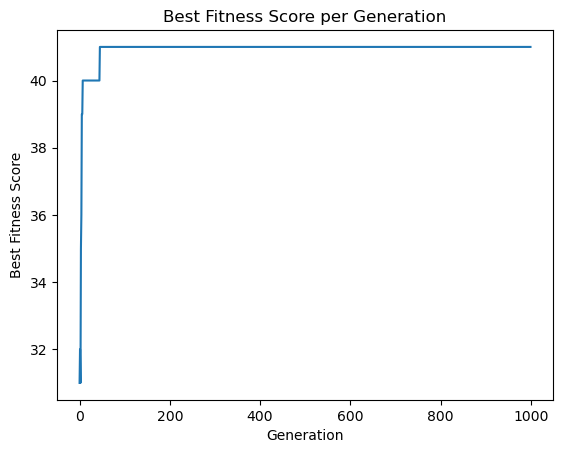

In [95]:
json_file_path = 'datasets/easy_dataset_1.json'     ### change the dataset if needed

data = load_data(json_file_path)
(N, K, R, min_reviews_per_paper, max_reviews_per_paper,
    preference_matrix, friendship_matrix, authorship_matrix) = parse_json(data)

best_assignment, fitness_scores = genetic_algorithm(
    num_papers=N, 
    num_reviewers=K, 
    reviewer_capacity=R, 
    min_reviews=min_reviews_per_paper, 
    max_reviews=max_reviews_per_paper, 
    preference_matrix=preference_matrix,
    friendship_matrix=friendship_matrix,
    authorship_matrix=authorship_matrix,
    generations=1000,
    pop_size=50,
    selection_method='rank-based',
    crossover_method='one-point',
    mutation_method='swap'
)

print("The best is: ", best_assignment)

#### Plot the fitness scores
plt.plot(fitness_scores)
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Best Fitness Score per Generation')
plt.show()


##### Test the first functions
# print(parse_json(data))
# assignment = generate_random_assignment(N, K, R, min_reviews_per_paper, max_reviews_per_paper)
# fitness_score = fitness_function(assignment, preference_matrix, friendship_matrix, 
#                                 authorship_matrix, R, min_reviews_per_paper, max_reviews_per_paper)       
# print(assignment)
# print("Score: ", fitness_score)

### Task 2: Crossover & Mutation

In [62]:
import pygad

In [73]:
def pygad_fitness(pygad_instance, solution, solution_idx):
    assignment = solution.reshape((K, N))
    return fitness_function(assignment, preference_matrix, friendship_matrix, authorship_matrix,
                            R, min_reviews_per_paper, max_reviews_per_paper)

In [74]:
json_file_path = 'datasets/easy_dataset_1.json'     ### change the dataset if needed

data = load_data(json_file_path)
(N, K, R, min_reviews_per_paper, max_reviews_per_paper,
    preference_matrix, friendship_matrix, authorship_matrix) = parse_json(data)

In [111]:
def select_parents(population, fitness_scores):                                   #### find the parents
    fitness_sum = sum(fitness_scores)
    probabilities = [score / fitness_sum for score in fitness_scores]
    parents = random.choices(population, weights=probabilities, k=2)
    return parents
 
def crossover(pygad_instance, parent1, parent2):     
    print(parent1)                                             #### crossover by swapping
    crossover_point = random.randint(0, K - 1)
    child1 = np.vstack((parent1[:crossover_point, :], parent2[crossover_point:, :]))
    child2 = np.vstack((parent2[:crossover_point, :], parent1[crossover_point:, :]))
    return child1, child2

def mutate(assignment, R, min_reviews, max_reviews):                             #### mutate by flipping a random entry 0->1 or 1->0
    num_rev, num_pap = assignment.shape
    i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    assignment[i, j] = 1 - assignment[i, j]  
    
    if assignment[i, :].sum() > R:
        assignment[i, j] = 0
    if assignment[i, :].sum() < min_reviews:
        assignment[i, j] = 1
    elif assignment[i, :].sum() > max_reviews:
        assignment[i, j] = 0
    return assignment

In [112]:
ga_instance = pygad.GA(
                        fitness_func=pygad_fitness,
                        num_generations=100,
                        num_parents_mating=2,
                        sol_per_pop=20,
                        num_genes= N * K,              
                        gene_space=[0, 1],            
                        mutation_type="swap",
                        crossover_type=crossover,
                        allow_duplicate_genes=True,  
                        stop_criteria="saturate_15"   
                    )
ga_instance.run()

tuple indices must be integers or slices, not tuple
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\intelsys\lib\site-packages\pygad\pygad.py", line 1962, in run
    self.run_crossover()
  File "c:\Users\user\anaconda3\envs\intelsys\lib\site-packages\pygad\pygad.py", line 2221, in run_crossover
    self.last_generation_offspring_crossover = self.crossover(self.last_generation_parents,
  File "C:\Users\user\AppData\Local\Temp\ipykernel_40372\519384566.py", line 10, in crossover
    child1 = np.vstack((parent1[:crossover_point, :], parent2[crossover_point:, :]))
TypeError: tuple indices must be integers or slices, not tuple


(19, 25)


TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
best_sol, best_solution_fitness, _ = ga_instance.best_solution()
best_sol = best_sol.reshape((K,N))
best_sol

array([[1, 1, 0, 1, 1],
       [1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1],
       [0, 1, 1, 1, 0],
       [1, 0, 0, 0, 1]])